# Assignment 2 - k-Nearest Neighbors

***

## Team
- Kevin Huber
- Markus Kaufmann
- Luca Rava

***


## Task

<br>
*AutoScout24 provided us with a dump of their productive database. You are assigned to train
a prediction model for the selling price of second-hand cars, which in the future shall enable
the platform to automatically suggest an adequate selling price whenever a customer uploads
a new sale advertisement.*
<br><br>
***


### 1. Import & inspect the data; transform categorical attributes

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv(r"AutoScout24 Dataset.csv")
print(data.columns)
print(data.head())

Index(['Name', 'Price', 'Mileage', 'Registration', 'Color', 'Doors',
       'Horsepower', 'EngineSize', 'Seats', 'Cylinders', 'Gears', 'Year'],
      dtype='object')
                       Name   Price  Mileage Registration      Color  Doors  \
0      MERCEDES-BENZ SL 500   44800    27600   1996-10-01  anthrazit      2   
1                 BMW 740iL   22800    18300   1999-05-01  anthrazit      4   
2  AUDI A8 4.2 FSI quattro   183710      650   2008-08-01  anthrazit      5   
3    OPEL Zafira 2.2i Cosmo   19900    32000   2006-02-01  anthrazit      5   
4        VOLVO V70 D5 AWD A   18999   118000   2003-02-01  anthrazit      5   

   Horsepower  EngineSize  Seats  Cylinders  Gears  Year  
0         320        4973      2          8      5  1996  
1         286        4398      5          8      5  1999  
2         350        4172      5          8      6  2008  
3         150        2198      7          4      6  2006  
4         163        2401      5          5      5  2003  



***

### Inspection
<br>
- Die Spalte mit den Namen der Autos (_`Name`_) ist bezüglich der späteren Prozessierung irrelevant. Column kann also gedroppt werden.
- Die Daten können allgemeine Fehler enthalten, welche auf Verständnisdiskrepanzen sowie Eingabefehler zurückzuführen sind. So zum Beispiel die Anzahl Türen (_`Doors`_). Es ist möglich, dass nicht jeder Benutzer, welcher ein Auto inseriert, die korrekte Anzahl Türen gemäss Hersteller-Datenblatt angibt (z.B. Verständniskonflikt 2 Türen <-> 3 Türen).

<br>
Nachfolgend wird das Dataset auf die Plausibilität der Inhalte der einzelnen Attribute (Columns) untersucht.
<br><br>

#### Price

- Die Preisrange liegt zwischen `CHF 300.- < x < CHF 698'000.-`, was bezüglich der Mileage, dem Jahrgang und dem Modell der einzelnen Autos durchaus Sinn machen kann. Besonders beachtet wurden hierbei diejenigen Autos, welche den niedrigsten (CHF 300.-) bzw. den höchsten Preis (CHF 698'000.-) aufweisen.
- Insgesamt 166 Fahrzeuge liegen preislich unter CHF 1'000.-
    - Klingt ziemlich suspekt, kann aber gut möglich sein, wenn man die Wertebereiche der Kilometerstände (`70'000 km < x < 371'000 km`) sowie der Jahrgänge (`1992 < x < 2006`) miteinbezieht
<br><br>

#### Mileage

- Wertebereich der Kilometerstände: `0 km < x < 1'530'000 km`
- Besonders auffällig: Es gibt 3 Autos, die einen sehr hohen Kilometerstand haben:
<br><br>
    - TOYOTA Celica 1.8 VVT-i / 2000 / `623'750 km`
        - Wert ist sehr hoch, jedoch nicht unmöglich
        - Der Preis (`CHF 7'900.-`) ist für den Kilometerstand ziemlich hoch angesetzt, doch das kann der Besitzer des Autos selbst festlegen
        - Datensatz könnte die spätere Prediction verfälschen (Verhältnis Jahr / Mileage / Preis)
    <br><br>
    - SUBARU Legacy 2.5 Outback A / 1997 / `999'999 km`
        - Wert scheint sehr suspekt
        - Ein Besuch auf _autoscout24.ch_ zeigt, dass es einige Benutzer gibt, welche sogar Autos mit `999'999'999 km` inseriert haben. Was genau dahinter steckt, ist nicht klar (evtl. Kilometerstand nicht mehr ablesbar)
        - Wert ist sehr unwahrscheinlich und sollte daher für die weitere Prozessierung nicht beachtet werden
    <br><br>
    - HONDA FR-V 1.7 Comfort / 2006 / `1'530'000 km`
        - Wert ist sehr hoch, jedoch nicht unmöglich
        - Der Preis (`CHF 7'990.-`) ist für den Kilometerstand äusserst hoch angesetzt, doch das kann der Besitzer des Autos selbst festlegen
        - Datensatz könnte die spätere Prediction verfälschen (Verhältnis Jahr / Mileage / Preis)
    <br><br>

#### Registration

- Wertebereich der Registrationsdaten: `01.01.1900 < x < 01.01.2014`
- Besonders auffällig: Es gibt 1 Auto, welches definitiv ein falsches Registrationsdatum eingetragen hat:
<br><br>
    - HYUNDAI i30 1.6 GDI STYLE / `01.01.1900`
        - Falsche Datenangabe des Registrationsdatums
        - Die typgleichen / ähnlichen Modelle sind alle in den Jahren 2012 & 2013
        - Datensatz sollte entfernt werden, da dieser die spätere Prediction verfälschen kann
    <br><br>

#### Color

- Bei den Farben der Autos scheint es keine ungültigen oder unplausiblen Werte zu geben
<br><br>

#### Doors

- Wertebereich der Anzahl Türen: `2 < x < 6`
- Wie bereits erwähnt, ist es möglich, dass nicht jeder Benutzer, welcher ein Auto inseriert, die korrekte Anzahl Türen gemäss Hersteller-Datenblatt angibt (z.B. Verständniskonflikt 2 Türen <-> 3 Türen).
- Es ist somit gut möglich, dass es z.B. Datensätze gibt, welche 2 Türen angegeben haben, aber nach Herstellerangabe über 3 Türen verfügen. Dies bei jedem Datensatz zu überprüfen wäre jedoch ein zu hoher Aufwand
- Besonders auffällig sind die Autos mit 6 Türen:
<br><br>
    - BMW 120i / 2005 / 5 Sitze
        - Hierbei handelt es sich wahrscheinlich um eine Falschangabe
        - Laut Hersteller werden die Modelle der 1er-Serie von BMW als 3- oder 5-Türer implementiert
        - Somit handelt es sich ziemlich sicher um einen 5-Türer
        - Verwandte / gleiche Modelle aus dem selben Jahr werden mit 3 oder 5 Türen angegeben (siehe Dataset)
        <br><br>
    - MERCEDES-BENZ Vito 116 CDI EL A / 2011 / 8 Sitze
        - Hierbei handelt es sich wahrscheinlich um eine Falschangabe
        - Es handelt sich ziemlich sicher um einen 5-Türer
        - Verwandte / gleiche Modelle aus dem selben Jahr werden mit 5 Türen angegeben (siehe Dataset)
    <br><br>

#### Horsepower

- Wertebereich der Fahrzeugleistung: `40 PS < x < 777 PS`
- Die einzelnen Werte scheinen plausibel
- Es gibt keine Ausreisser
<br><br>

#### EngineSize

- Wertebereich der Hubraums: `599 ccm (0.6 l) < x < 8285 ccm (8.3 l)`
- Die einzelnen Werte scheinen plausibel
- Es gibt keine Ausreisser
<br><br>

#### Seats

- Wertebereich der Anzahl Sitze: `2 < x < 14`
- Alle Werte <= 9 scheinen plausibel zu sein
- Besonders auffällig sind die beiden Autos mit 11 resp. 14 Sitzen:
<br><br>
    - VW T4 Caravelle 2.5TDI ABS / 2001 / 4 Türen / `11 Sitze`
        - Laut https://de.wikipedia.org/wiki/VW_T4 sind maximal 9 Sitze realisierbar
        - Falschangabe
    <br><br>
    - MERCEDES-BENZ 316 CDI / 2012 / 4 Türen / `14 Sitze`
        - Dieser Wert ist nicht unwahrscheinlich, da gemäss https://de.wikipedia.org/wiki/Mercedes-Benz_Sprinter je nach Variante bis zu 30 Sitzplätze integriert werden können
<br><br>


#### Cylinders

- Wertebereich der Anzahl Zylinder: `2 < x < 12`
- Alle Werte scheinen plausibel zu sein
- Es gibt in der Tat Motoren mit 2, 3 oder 5 Zylindern (nebst den bekannten mit 4, 6, 8, 10 oder 12 Zylindern)
- Es gibt keine Ausreisser
<br><br>


#### Gears

- Wertebereich der Anzahl Gänge: `1 < x < 8`
- Alle Werte scheinen plausibel zu sein
- Besonders auffällig sind zwei Autos:
<br><br>
    - FISKER Karma EcoSport / 2012 / 4 Türen / `1 Gang`
        - Laut https://de.wikipedia.org/wiki/Fisker_Karma handelt es sich bei diesem Auto um einen Plug-in-Hybrid, welcher 2 Elektromotoren sowie einen Verbrennungsmotor besitzt. Der Letztere nimmt dabei die Funktion einer Energiequelle für den Generator an, welcher den Elektromotoren additionale Energie (Strom) zur Verfügung stellt. Ein 1-Gang-Getriebe macht bei elektrisch angetriebenen Autos durchaus Sinn (vgl. mit Tesla).
        <br><br>
    - DAIHATSU Cuore Mio / 1997 / 3 Türen / `3 Gänge`
        - Laut https://de.wikipedia.org/wiki/Daihatsu_Cuore#Mira_/_Cuore_L501_(1995%E2%80%932000) ist dieses Auto mit einem 3-Stufen-Automatikgetriebe ausstattbar.
<br><br>


#### Year

- Wertebereich des Jahrgangs: `1900 < x < 2014`
- Jahrgang entspricht dem selben Jahr wie innerhalb des Registrationsdatums angegeben (siehe Spalte _Registration_)
- Die Spalte _Registration_ kann somit gedroppt werden (Grund: Datenredundanz)
<br><br>

### Check for duplicates

In [2]:
row_count = data.shape[0]
data = data.drop_duplicates()
print("Duplicates deleted: " + str(row_count - data.shape[0]))

Duplicates deleted: 470


<br>
### Data Cleaning - Remove unlikely data
<br>
Auf Grund der initial getätigten Dateninspektion (siehe Kapitel _Inspection_) werden diejenigen Records aus dem Dataset entfernt, welche die spätere Prozessierung mittels _k-NN regression model_ negativ beeinflussen bzw. verfälschen könnten.
<br>
Zudem können die beiden Columns `Name` und `Registration` entfernt werden, da sie entweder irrelevante Daten (Namen der Fahrzeuge) oder Datenredundanzen (Registrationsdatum der Fahrzeuge <-> Spalte `Year`) enthalten.
<br><br>

In [3]:
# Comment: you should determine the outlier range automatically 
# from the data distribution
# see lecture: Basics
# see chapter "Inspection", subchapter "Mileage"
data = data.drop(data[((data["Name"]=="TOYOTA Celica 1.8 VVT-i") & (data["Mileage"]==623750))].index)
data = data.drop(data[((data["Name"]=="SUBARU Legacy 2.5 Outback A") & (data["Mileage"]==999999))].index)
data = data.drop(data[((data["Name"]=="HONDA FR-V 1.7 Comfort") & (data["Mileage"]==1530000))].index)

# see chapter "Inspection", subchapter "Registration"
data = data.drop(data[((data["Name"]=="HYUNDAI i30 1.6 GDI STYLE") & (data["Registration"]=="1900-01-01"))].index)

# drop irrelevant / redundant columns
data = data.drop(columns=['Name', 'Registration'])

<br>
### Transform categorical attributes

In [4]:
data = pd.get_dummies(data)
print(data.columns)

Index(['Price', 'Mileage', 'Doors', 'Horsepower', 'EngineSize', 'Seats',
       'Cylinders', 'Gears', 'Year', 'Color_anthrazit', 'Color_beige',
       'Color_blau', 'Color_bordeaux', 'Color_braun', 'Color_gelb',
       'Color_gold', 'Color_grau', 'Color_grün', 'Color_orange', 'Color_pink',
       'Color_rot', 'Color_schwarz', 'Color_silber', 'Color_türkis',
       'Color_violett', 'Color_weiss'],
      dtype='object')



***

### 2. Search for anomalies and suggest appropriate measures

Etwaige Anomalien wurden bereits bei der Analyse der einzelnen Attribute (innerhalb des Kapitels _Inspection_) akzentuiert und bereinigt (Kapitel _Data Cleaning_).


***

### 3. Inspect correlations between the price and other attributes
<br>


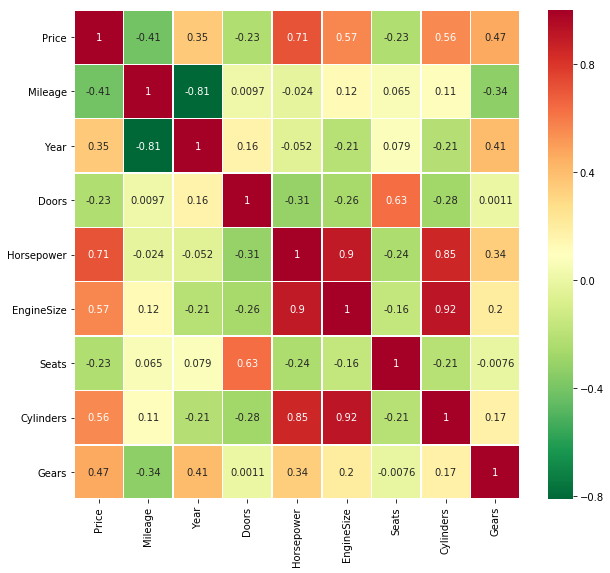

In [5]:
data = data.loc[:,['Price', 'Mileage', 'Year', 'Doors', 'Horsepower', 'EngineSize', 'Seats', 'Cylinders', 'Gears']]
plt.subplots(figsize=(10, 9))
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn_r', linewidths=0.5)
plt.show()

<br>
### Analysis
<br>
Die stärksten Korrelationen bezüglich des Preises bestehen bei folgenden Attributen:
<br><br>

Attribut | Korrelation
:-- | :--
`Horsepower` | 0.71
`EngineSize` | 0.57
`Cylinders` | 0.56
`Gears` | 0.47
`Year` | 0.35

<br>
Die negative Korrelation zwischen dem Preis und der `Mileage` (Korrelation: `-0.41`) war ebenfalls zu erwarten - denn je kleiner der Kilometerstand, desto teurer wird in der Regel ein Fahrzeug angeboten.
<br>


***

### 4. Split your data into 80% train and 20% test set and normalize your data
<br>
### Splitting data into train and test set

In [6]:
from sklearn.model_selection import train_test_split

# Split into 80% training and 20% test set
train, test = train_test_split(data, test_size=0.2)

# Separate target and features
X_train = train.drop('Price', axis=1)
X_test = test.drop('Price', axis=1)

y_train = train.Price
y_test = test.Price

<br>
### Normalize data

In [7]:
# Determine mean and std on training set
mean = X_train.mean()
std = X_train.std()

# Normalize feature tables by Z-score
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


***

### 5. Train a k-NN regression model and determine the best choice for k
<br>

### Apply _unweighted_ k-NN algorithm for different k > 0

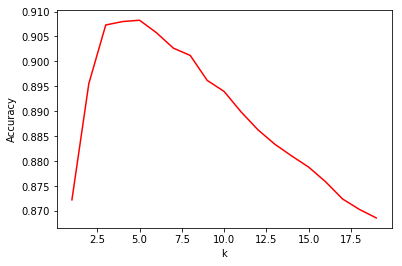

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import explained_variance_score

u_scores = []
u_acc = []
k_range = list(range(1,20))

for k in k_range :
    knn = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = explained_variance_score(y_test, y_pred)
    u_scores.append(acc)
    u_acc.append((k, y_test, y_pred, acc))
    
plt.plot(k_range, u_scores, color="red")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show() 

<br>
### Apply _weighted_ k-NN algorithm for different k > 0

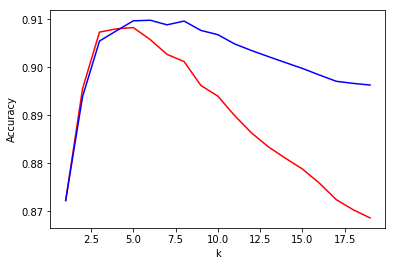

In [9]:
w_scores = []
w_acc = []

for k in k_range :
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = explained_variance_score(y_test, y_pred)
    w_scores.append(acc)
    w_acc.append((k, y_test, y_pred, acc))
    
plt.plot(k_range, u_scores, color="red")
plt.plot(k_range, w_scores, color="blue")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

<br>
### 5.1 Measure prediction quality with R<sup>2</sup> and consult your favorited text book in order to correctly interpret this measure of explained variance
<br>

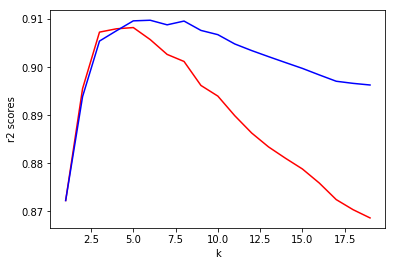

Max r2 Score unweighted: 0.908242372692 with k: 4
Max r2 Score weighted: 0.909765562148 with k: 5


In [10]:
from sklearn.metrics import r2_score

u_r2_score = []
w_r2_score = []

#print("---------------------------")
#print("Unweighted k-NN algorithm: ")
for acc_entry in u_acc:
    #print("")
    #print("k: " + str(acc_entry[0]))
    #print("acc: " + str(acc_entry[3]))
    r2_score_for_k = r2_score(acc_entry[1], acc_entry[2], multioutput="raw_values")
    u_r2_score.append(r2_score_for_k)
    #print("r2 score: " + str(r2_score_for_k))

#print("")
#print("---------------------------")
#print("Weighted k-NN algorithm: ")
for acc_entry in w_acc:
    #print("")
    #print("k: " + str(acc_entry[0]))
    #print("acc: " + str(acc_entry[3]))
    r2_score_for_k = r2_score(acc_entry[1], acc_entry[2], multioutput="raw_values")
    w_r2_score.append(r2_score_for_k)
    #print("r2 score: " + str(r2_score_for_k))
    

plt.plot(k_range, u_r2_score, color="red")
plt.plot(k_range, w_r2_score, color="blue")
plt.xlabel('k')
plt.ylabel('r2 scores')
plt.show()
u_r2_max = max(u_r2_score)
print("Max r2 Score unweighted: " + str(u_r2_max[0]) + " with k: " + str(u_r2_score.index(u_r2_max)))
w_r2_max = max(w_r2_score)
print("Max r2 Score weighted: " + str(w_r2_max[0]) + " with k: " + str(w_r2_score.index(w_r2_max)))

<br>
### 5.2 Measure prediction quality as the (mean) absolute price difference between your model and the ground truth
<br>

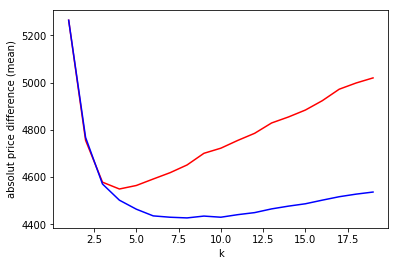

Min absoult price difference unweighted: 4549.6239609 with k: 3
Min absoult price difference weighted: 4427.16038567 with k: 7


In [11]:
#print("---------------------------")
#print("Unweighted k-NN algorithm: ")

u_mean = []
w_mean = []

for acc_entry in u_acc:
    #print("")
    #print("k: " + str(acc_entry[0]))
    truth_col = acc_entry[1]
    pred_col = acc_entry[2]
    diff = []
    for index, truth in enumerate(truth_col):
        pred = pred_col[index]
        diff.append(abs(truth - pred))
    u_mean.append(pd.Series(diff).mean())

#print("")
#print("---------------------------")
#print("Weighted k-NN algorithm: ")
for acc_entry in w_acc:
    #print("")
    #print("k: " + str(acc_entry[0]))
    truth_col = acc_entry[1]
    pred_col = acc_entry[2]
    diff = []
    for index, truth in enumerate(truth_col):
        pred = pred_col[index]
        diff.append(abs(truth - pred))
    w_mean.append(pd.Series(diff).mean())
    
plt.plot(k_range, u_mean, color="red")
plt.plot(k_range, w_mean, color="blue")
plt.xlabel('k')
plt.ylabel('absolut price difference (mean)')
plt.show()
u_mean_min = min(u_mean)
print("Min absoult price difference unweighted: " + str(u_mean_min) + " with k: " + str(u_mean.index(u_mean_min)))
w_mean_min = min(w_mean)
print("Min absoult price difference weighted: " + str(w_mean_min) + " with k: " + str(w_mean.index(w_mean_min)))

<br>
**Die Exekution mehrerer Durchläufe resultierte in den folgenden Daten:**
<br><br>
<center>**Unweighted:**</center>

run | k | R<sup>2</sup> Score
:-- | :-- | :--
1 | 3 | 0.906496
2 | 3 | 0.913826 
3 | 4 | 0.926145
4 | 5 | 0.910161
5 | 3 | 0.905877
6 | 3 | 0.911533
7 | 4 | 0.920507
8 | 2 | 0.919110
9 | 4 | 0.914681
<br>
<center>**Weighted:**</center>

run | k | R<sup>2</sup> Score
:-- | :-- | :--
1 | 6 | 0.908385 
2 | 6 | 0.917298
3 | 6 | 0.930464 
4 | 7 | 0.915155
5 | 5 | 0.911095 
6 | 10 | 0.915280
7 | 7 | 0.925051
8 | 3 | 0.924393
9 | 7 | 0.915942
<br>
<center>**Unweighted:**</center>

run | k | absolut price difference (mean)
:-- | :-- | :--
1 | 4 | 4582.11
2 | 3 | 4550.54
3 | 4 | 4509.67  
4 | 3 | 4530.19
5 | 3 | 4592.94
6 | 3 | 4556.59
7 | 4 | 4513.39
8 | 5 | 4583.05
9 | 4 | 4567.50
<br>
<center>**Weighted:**</center>

run | k | absolut price difference (mean)
:-- | :-- | :--
1 | 7 | 4426.27
2 | 6 | 4395.42
3 | 7 | 4362.13  
4 | 8 | 4390.80
5 | 5 | 4455.62
6 | 7 | 4437.45
7 | 7 | 4376.73
8 | 9 | 4425.25
9 | 7 | 4454.08

<br>
***

## Conclusion
<br>
Nach mehreren Dürchlaufen sieht man, dass der gewichtete (_weighted_) k-NN-Algorithmus immer besser abschneidet als sein ungewichtetes (_unweighted_) Pendant. Zusätzlich ist der gewichtete k-NN-Algorithmus auch über eine grössere Range von _k_ stabiler, was an der blauen Linie innerhalb der einzelnen Graphen erkennbar ist.
<br><br>
Mit dem <span style="color:blue;">gewichteten</span> k-NN-Algorithmus ist eine gute Anzahl Nachbarn (_k_) <span style="color:blue;">7</span>, mit dem <span style="color:red;">ungewichteten</span> k-NN-Algorithmus ist das am besten geeignete _k_ = <span style="color:red;">4</span>.